# 3D Shapes and Trimesh

[Trimesh](https://trimesh.org/) is a well-known and well-maintained library for working with 3D geometry.

The goal of Trimesh is to "provide a full featured and well tested Trimesh object which allows for easy manipulation and analysis, in the style of the Polygon object in the Shapely library."

Trimesh and [](/reference/sketch_convert_shape) can greatly extend py5's ability to load and manipulate 3D objects, far exceeding what can be achieved with [](/reference/sketch_load_shape) and other `Py5Shape` methods.

Finally, know that Trimesh is a large and complex library. It is possible (likely) that there are Trimesh features that don't work well with py5's [](/reference/sketch_convert_shape) method. If you find something that doesn't work but probably should or have ideas for how py5's Trimesh integrations can be improved, please let us know by [opening an issue](https://github.com/py5coding/py5generator/issues) or starting a thread in [GitHub Discussions](https://github.com/py5coding/py5generator/discussions).

## Setup

Installing Trimesh by itself is acceptable but Trimesh is much more useful if you install its dependent libraries. At a minimum, you should install the easy to install dependencies with this command:

```bash
pip install trimesh[easy]
```

Refer to the [Trimesh Installation page](https://trimesh.org/install.html) for more information about Trimesh's dependencies and installation options.

Development of py5's integration code was done with Trimesh version 3.23. Version 4.0 was released shortly after but seems to work just as well as 3.23.

Installing [OpenSCAD](https://openscad.org/) or [Blender](https://www.blender.org/) on your computer may also be useful. Trimesh can use these to perform boolean operations on 3D objects.

If Trimesh is missing a dependent library needed for the functionality you want to use, it will provide you with an error message informing you of what you should install.

## Convert `trimesh.Scene` objects to `Py5Shapely` objects

Let's start by importing the Trimesh library and some classes we will use later.

In [1]:
import numpy as np

import trimesh
from trimesh.path import Path2D, Path3D
from trimesh.path.entities import Line
from trimesh.primitives import Box, Capsule, Cylinder, Sphere

import py5_tools
import py5

For our first example, we will use a 3D model file in [glTF format](https://en.wikipedia.org/wiki/GlTF) downloaded from [TurboSquid](https://www.turbosquid.com/). Our example is a
[Strawberry](https://www.turbosquid.com/3d-models/3d-strawberry-1962030) created by the artist [minimoku](https://www.turbosquid.com/Search/Artists/minimoku).

This model format can contain embedded texture images. Trimesh stores this texture information in a [TextureVisuals](https://trimesh.org/trimesh.visual.texture.html#trimesh.visual.texture.TextureVisuals) object. The [](/reference/sketch_convert_shape) will detect this and create a `Py5Shape` object with the texture.

Loading a complex 3D model in Trimesh may be slow. Don't load a model from within a Sketch unless absolutely necessary.  If you need to do this, load it once in `setup()`.

In [40]:
strawberry_scene = trimesh.load('models/Strawberry_gltf.gltf')

strawberry_scene

<trimesh.Scene(len(geometry)=1)>

A [trimesh.Scene](https://trimesh.org/trimesh.html#trimesh.Scene) object can contain one or more [trimesh.Trimesh](https://trimesh.org/trimesh.html#trimesh.Trimesh) objects. Both work equally well here.

We can use the [](/reference/sketch_convert_shape) method to effortlessly convert this model into a `Py5Shape` object.

In [3]:
def setup():
    global strawberry
    py5.size(300, 500, py5.P3D)
    strawberry = py5.convert_shape(strawberry_scene)
    assert isinstance(strawberry, py5.Py5Shape)

    # increase the model's scale and change its orientation
    strawberry.scale(50)
    strawberry.rotate_z(-py5.radians(90))

After converting the model into a `Py5Shape` object, we need to increase the scale and rotate it to change its orientation. Consider py5's coordinate system: the positive Y axis points towards the bottom of the drawing surface. It is likely that the 3D modeling program used to create this strawberry had a different coordinate system, perhaps with the positive Z axis pointing towards the top of the screen. Therefore, you will often need to do some rotations to get the result you want. Similarly, you will often need to adjust the scale.

These adjustments can be done to the model itself after converting the model into a `Py5Shape` object, as we did here in our `setup()` function. Alternatively, we can do global transformations in the `draw()` function before the drawing the `Py5Shape` object to the screen with [](/reference/sketch_shape).

You can also adjust the `trimesh.Trimesh` object using Trimesh's transformation tools, before the call to [](/reference/sketch_convert_shape). You will use Trimesh's [apply_transform()](https://trimesh.org/trimesh.html#trimesh.Trimesh.apply_transform) method to apply a transformation matrix to `trimesh.Trimesh` objects.

Now let's create a `draw()` method to draw the `Py5Shape` object with the [](/reference/sketch_shape) method.

In [4]:
y_rot = 0


def draw():
    global y_rot
    y_rot += 1

    py5.background(255)
    py5.ambient_light(64, 64, 64)
    py5.directional_light(220, 220, 220, 0, -1, -1)

    py5.translate(225, 400, 0)

    py5.rotate_z(py5.radians(-25))
    py5.rotate_x(py5.radians(-25))
    py5.rotate_y(py5.radians(y_rot))

    py5.shape(strawberry)

When we run this, the Strawberry will rotate along its main axis.

In [5]:
py5.run_sketch()

The result looks like this:

Output(layout=Layout(max_height='200px', overflow='auto'))

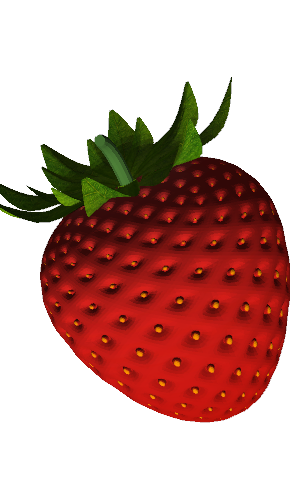

In [6]:
py5_tools.screenshot()

In [7]:
import time

time.sleep(1)

py5.exit_sketch()

Neat, huh? The [](/reference/sketch_convert_shape) method did all the heavy lifting to create the object and add apply the base color texture using the UV coordinates.

Note that `trimesh.Trimesh` objects can have additional texture maps for things such as surface normals or metallic roughness. Since the
default py5 polygon shader cannot make use of these texture maps, py5's [](/reference/sketch_convert_shape) method will not add them to the created `Py5Shape` object. One could write additional code to make use of them, however.

## Using Trimesh Primitives

Trimesh has a set of [primitive objects](https://trimesh.org/trimesh.primitives.html) such as [Box](https://trimesh.org/trimesh.primitives.html#trimesh.primitives.Box), [Capsule](https://trimesh.org/trimesh.primitives.html#trimesh.primitives.Capsule), [Cylinder](https://trimesh.org/trimesh.primitives.html#trimesh.primitives.Cylinder), and [Sphere](https://trimesh.org/trimesh.primitives.html#trimesh.primitives.Sphere).

The arrangement of triangles in a Trimesh Sphere is different from the arrangement created by py5's [](/reference/sketch_sphere) method. Capsules are kind of like cylinders with two half-spheres on each end. These primitives extend the basic shapes you can work with in py5.

Let's create a simple example showcasing these objects.

In [8]:
rot_z = 0

def setup():
    global primitives
    py5.size(500, 500, py5.P3D)

    py5.stroke_weight(1.5)

    primitives = py5.create_shape(py5.GROUP)

    box = py5.convert_shape(Box((80, 120, 70)))
    box.translate(150, 0, 0)
    primitives.add_child(box)

    # NOTE: Trimesh's Capsule `sections` parameter might have a bug
    capsule = py5.convert_shape(Capsule(70, 40, sections=12))
    capsule.translate(0, 150, 0)
    primitives.add_child(capsule)
    
    cylinder = py5.convert_shape(Cylinder(50, 80, sections=12))
    cylinder.translate(-150, 0, 0)
    primitives.add_child(cylinder)

    sphere = py5.convert_shape(Sphere(75, subdivisions=2))
    sphere.translate(0, -150, 0)
    primitives.add_child(sphere)
    

def draw():
    global rot_z
    rot_z += 1

    py5.background(204)
    py5.translate(py5.width / 2, py5.height / 2)
    py5.rotate_x(py5.radians(60))
    py5.rotate_z(py5.radians(rot_z))
    py5.shape(primitives)

Each of these [trimesh.Trimesh](https://trimesh.org/trimesh.html#trimesh.Trimesh) object primitives will inherit the drawing style active at the time [](/reference/sketch_convert_shape) is called. In this example, the stroke weight will be set to `1.5`.

When we run this, the primitive shapes will rotate around for us to see.

In [9]:
py5.run_sketch()

In [10]:
time.sleep(4)

Here's a screenshot of what it looks like:

Output(layout=Layout(max_height='200px', overflow='auto'))

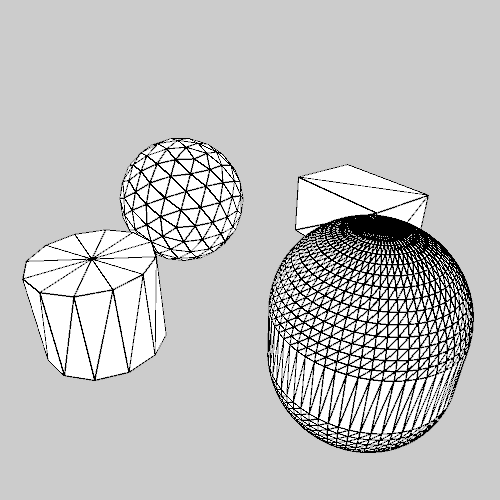

In [11]:
py5_tools.screenshot()

In [12]:
time.sleep(1)

py5.exit_sketch()

A final comment on drawing styles: Trimesh objects can have their own drawing style information ([ColorVisuals](https://trimesh.org/trimesh.visual.color.html#trimesh.visual.color.ColorVisuals)) instead of texture-based styles ([TextureVisuals](https://trimesh.org/trimesh.visual.texture.html#trimesh.visual.texture.TextureVisuals)). If [](/reference/sketch_convert_shape) detects a`ColorVisuals` object, it will use that drawing style information instead of py5's active drawing style.

Also, be aware that some Trimesh library operations seem to add `ColorVisuals` objects to their output. This can be a bit confusing because your calls to py5's style methods such as [](/reference/sketch_stroke) and [](/reference/sketch_fill) will have no effect. Be aware of this possibility to avoid coding frustrations. If you suspect this is happening, one easy way to address this is to call the [](/reference/py5shape_disable_style) method to remove Trimesh's drawing style settings from the `Py5Shape` object and take control of the drawing style.

## `trimesh.Path2D` and `trimesh.Path3D` objects

In addition to [trimesh.Scene](https://trimesh.org/trimesh.html#trimesh.Scene) and [trimesh.Trimesh](https://trimesh.org/trimesh.html#trimesh.Trimesh) objects, py5's [](/reference/sketch_convert_shape) method can also convert [trimesh.path.Path2D](https://trimesh.org/trimesh.path.html#trimesh.path.Path2D) and [trimesh.path.Path3D](https://trimesh.org/trimesh.path.html#trimesh.path.Path3D).

Creating `Path2D` and `Path3D` objects directly is a bit tedious. You might do so with code like this:

In [13]:
line1 = Line(
    np.random.choice(np.arange(8), replace=False, size=4),
)
line2 = Line(
    np.random.choice(np.arange(8), replace=False, size=4),
)

path2d = Path2D(
    entities=[line1, line2],
    vertices=250 * np.random.random((8, 2)),
    colors=np.random.randint(255, size=(2, 3)).astype(np.uint8),
)

Next, `path2d` could be converted to a `Py5Shape` object with [](/reference/sketch_convert_shape). It would look like a 2D line with random vertices and colors. However, that's a lot of code to create something that could be done more simply with the methods already provided by py5. Most likely you would never go through the trouble of creating a `Path2D` object like this.

More likely you get `Path2D` or `Path3D` objects as the output of other Trimesh methods. Let's explore this by using Trimesh's [section_multiplane()](https://trimesh.org/trimesh.base.html#trimesh.base.Trimesh.section_multiplane) method to create slices of our Strawberry model.

First we will need to extract the [trimesh.Trimesh](https://trimesh.org/trimesh.html#trimesh.Trimesh) object from the [trimesh.Scene](https://trimesh.org/trimesh.html#trimesh.Scene) object.

In [14]:
strawberry_model = strawberry_scene.geometry['strawberry']

strawberry_model

<class 'trimesh.base.Trimesh'>


Next we will create the 2D slices, which will then be converted to slices that exist in 3D space.

In [15]:
xmin, xmax = strawberry_model.bounds[:, 0]

strawberry_slices_2d = strawberry_model.section_multiplane(
    (0, 0, 0), (1, 0, 0), np.linspace(xmin, xmax, num=40)
)
strawberry_slices_3d = [
    slice.to_3D() for slice in strawberry_slices_2d if slice is not None
]

In our `setup()` function we can convert each slice into a `Py5Shape` object and then add them to a `GROUP` shape.

In [16]:
def setup():
    global strawberry
    py5.size(300, 500, py5.P3D)

    # convert each slices into a Py5Shape object
    strawberry_slices = [py5.convert_shape(slice) for slice in strawberry_slices_3d]
    # assemble the Py5Shape objects into a GROUP Py5Shape object
    strawberry = py5.create_shape(py5.GROUP)
    for slice in strawberry_slices:
        strawberry.add_child(slice)

    # increase the model's scale and change its orientation
    strawberry.scale(50)
    strawberry.set_stroke_weight(0.025)
    strawberry.rotate_z(-py5.radians(90))


Now we can create the `draw()` function and run the Sketch.

In [17]:
def draw():
    global y_rot
    y_rot += 1

    py5.background(255)

    py5.translate(225, 400, 0)
    py5.rotate_z(py5.radians(-25))
    py5.rotate_x(py5.radians(-25))
    py5.rotate_y(py5.radians(y_rot))

    py5.shape(strawberry)


py5.run_sketch()

The Sketch will look like this:

Output(layout=Layout(max_height='200px', overflow='auto'))

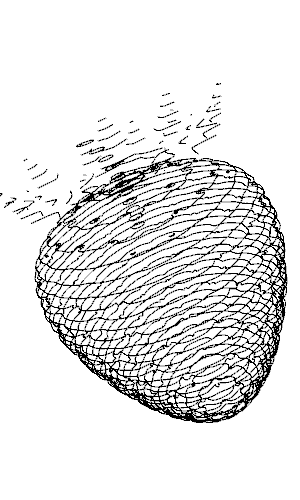

In [18]:
py5_tools.screenshot()

In [19]:
time.sleep(1)

py5.exit_sketch()

## `trimesh.PointCloud`

Finally, py5's [](/reference/sketch_convert_shape) method supports `trimesh.PointCloud` objects. To make this interesting, let's create a `trimesh.PointCloud` object from the Strawberry model's vertices.

In [34]:
strawberry_pointcloud = trimesh.PointCloud(strawberry_model.vertices)

In the `setup()` function we can convert the `trimesh.PointCloud` object to a `Py5Shape` object using [](/reference/sketch_convert_shape), just like before.

In [37]:
def setup():
    global strawberry
    py5.size(300, 500, py5.P3D)

    strawberry = py5.convert_shape(strawberry_pointcloud)
    
    # increase the model's scale and change its orientation
    strawberry.scale(50)
    strawberry.set_stroke_weight(0.0005)
    strawberry.rotate_z(-py5.radians(90))

Note that this example is a bit contrived in that we could have also created the `Py5Shape` object from the vertices directly, without using `trimesh.PointCloud`:

```python
    strawberry = py5.create_shape()
    with strawberry.begin_shape(py5.POINTS):
        strawberry.vertices(strawberry_model.vertices)
```

We can run the Sketch using the same `draw()` function as before.

In [38]:
py5.run_sketch()

Here's what that looks like:

Output(layout=Layout(max_height='200px', overflow='auto'))

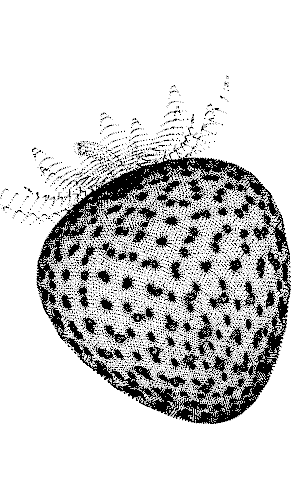

In [39]:
py5_tools.screenshot()

In [ ]:
time.sleep(1)

py5.exit_sketch()

## Options

textures, lines_allow_fill